In [3]:
import numpy as np
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


Loading train test json files

In [4]:
train_json = open('train.json')
test_json = open('test.json')

train_data = json.load(train_json)
test_data = json.load(test_json)

In [5]:
list(train_data.keys())[0]

'net lived lofty expectation month basketball long shot team utilized expected bench player averaging minute'

In [6]:
list(train_data.values())[0]

'16'

In [7]:
list(test_data.keys())[0]

'mcdonald royal cheese france facing competition burger king signing deal expand country miami based chain week partnering restaurant operator groupe olivier bertrand build'

In [8]:
train_event_ids = list(train_data.values())
test_event_ids = list(test_data.values())

In [9]:
# List of all training sentences
train_sentences = list(train_data.keys())

In [10]:
# List of all test sentences
test_sentences = list(test_data.keys())

##TF-IDF Baseline model

In [27]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the training data
train_tfidf_embeddings = tfidf_vectorizer.fit_transform(train_data)

# Transform the testing data
test_tfidf_embeddings = tfidf_vectorizer.transform(test_data)

In [57]:
# Get feauture names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names

array(['aaa', 'aaaaaaa', 'aaaargh', ..., 'zuckerman', 'zum', 'zurich'],
      dtype=object)

Using K-nearest neighbors

In [58]:
n_neighbors = 5  # 5 neighbours to get similarity
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
# train on train_tf_embeddings
knn.fit(train_tfidf_embeddings)

NearestNeighbors(metric='cosine')

In [59]:
# Test on the test set
distances, indices = knn.kneighbors(test_tfidf_embeddings)

In [60]:
indices

array([[3200, 3092, 5220, 2290, 3112],
       [4716,  463, 1925, 4726, 5526],
       [3229, 4192, 1610, 2455, 1791],
       ...,
       [3541,  633,   42, 4695, 2090],
       [3760,  280, 5152,  758, 2222],
       [3950, 2468, 1062, 2019,  293]])

In [61]:
distances

array([[0.0847812 , 0.09239085, 0.15772941, 0.55076739, 0.61652103],
       [0.48685961, 0.52175902, 0.54543386, 0.56864335, 0.58802724],
       [0.76528996, 0.82333673, 0.83154158, 0.84918192, 0.85173778],
       ...,
       [0.76391361, 0.79457697, 0.80669327, 0.81232929, 0.82309956],
       [0.88052357, 0.88983049, 0.8918553 , 0.89578208, 0.89589616],
       [0.66848301, 0.76719841, 0.77029911, 0.81397398, 0.83721044]])

Prediction on test set

In [11]:
# N values to get top1, top2 and top3 accuracy
n_values = [1, 3, 5]

In [12]:
len(test_data)

2831

In [13]:
total_predictions = len(test_data)

In [52]:
for n in n_values:
    correct_predictions = 0

    for i in range(total_predictions):
      # a list of indices representing the neighbors of the current data point within the dataset
        neighbor_indices = indices[i]
        # Checks the indices from the training set and extracts the event IDs of the neighboring data points.
        neighbor_event_ids = [train_event_ids[idx] for idx in neighbor_indices]
        correct_event_id = test_event_ids[i]

        # Check if the correct event ID is among the top N predictions
        if correct_event_id in neighbor_event_ids[:n]:
            correct_predictions += 1

    top_n_accuracy = correct_predictions / total_predictions
    print(f"Top-{n} Accuracy: {top_n_accuracy:.4f}")

Top-1 Accuracy: 0.7976
Top-3 Accuracy: 0.9085
Top-5 Accuracy: 0.9315


##S-bert model

In [ ]:
!pip install -U sentence-transformers

In [15]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [77]:
# Encode all train_embeddings using the SBERT model
train_sbert_embeddings = model.encode(train_sentences, convert_to_tensor=True)

Prediction on test data

In [80]:
# Encode all train_embeddings using the SBERT model
test_sbert_embeddings = model.encode(test_sentences, convert_to_tensor=True)

In [84]:
test_sbert_embeddings

tensor([[-3.7833e-01, -4.2994e-01, -4.6630e-01,  ..., -5.9780e-01,
          2.3580e-01, -5.8397e-01],
        [-4.7452e-01, -9.4299e-02, -1.3851e-01,  ..., -8.7546e-02,
          1.9439e-01,  3.7230e-01],
        [ 3.2794e-01,  1.8217e-01, -2.2941e-01,  ..., -5.3607e-01,
         -4.8081e-01,  1.2468e-01],
        ...,
        [ 1.3726e-02, -1.5866e-01,  3.2829e-01,  ..., -3.4480e-02,
         -9.9161e-02, -2.0366e-01],
        [-3.7794e-01,  3.3973e-01, -4.1621e-01,  ..., -1.8772e-01,
         -1.0720e-02,  2.3644e-01],
        [-1.0506e-01,  5.5107e-01, -2.8484e-04,  ..., -5.5066e-01,
         -1.8693e-01,  9.4410e-02]])

Use K-nearest neighbours for similarity

In [86]:
n_neighbors = 5  # 5 neighbours to get similarity
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
# train on train_sbert_embeddings
knn.fit(train_sbert_embeddings)

NearestNeighbors(metric='cosine')

In [91]:
distances, indices = knn.kneighbors(test_sbert_embeddings)

In [92]:
distances

array([[0.03179365, 0.03610271, 0.0556556 , 0.3059789 , 0.31886876],
       [0.22019935, 0.26287335, 0.2970789 , 0.3509773 , 0.39075   ],
       [0.47596073, 0.4771163 , 0.50718516, 0.5095843 , 0.5097606 ],
       ...,
       [0.3633812 , 0.3883108 , 0.38966024, 0.4277284 , 0.4293852 ],
       [0.6136391 , 0.6257176 , 0.6288748 , 0.6321218 , 0.63331044],
       [0.44674754, 0.5384413 , 0.5490542 , 0.5519072 , 0.5529064 ]],
      dtype=float32)

In [93]:
indices

array([[3200, 5220, 3092, 1847, 2290],
       [4716, 1925, 4726,  587,  641],
       [4771,  152, 3654, 5089, 4355],
       ...,
       [ 217, 5588, 1894, 3289,  380],
       [4123, 1281, 2131, 3436, 4620],
       [3950,  422, 3075, 2911,  563]])

In [95]:
for n in n_values:
    correct_predictions = 0

    for i in range(total_predictions):
        neighbor_indices = indices[i]
        neighbor_event_ids = [train_event_ids[idx] for idx in neighbor_indices]
        correct_event_id = test_event_ids[i]

        # Check if the correct event ID is among the top N predictions
        if correct_event_id in neighbor_event_ids[:n]:
            correct_predictions += 1

    top_n_accuracy = correct_predictions / total_predictions
    print(f"Top-{n} Accuracy: {top_n_accuracy:.4f}")

Top-1 Accuracy: 0.8523
Top-3 Accuracy: 0.9198
Top-5 Accuracy: 0.9378


### Doc2Vec embedding model



Load model

In [17]:
import torch

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
train_tokenized = [word_tokenize(sentence.lower()) for sentence in train_sentences]
test_tokenized = [word_tokenize(sentence.lower()) for sentence in test_sentences]

In [38]:
train_tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(train_tokenized)]

Create Doc2Vec **model**

In [40]:
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(train_tagged_data)
model.train(train_tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

Use K-nearest neighbors

In [42]:
test_embeddings = [model.infer_vector(test_sentence) for test_sentence in test_tokenized]

In [43]:
test_embeddings = np.array(test_embeddings)

In [45]:
k = 5  # Change this to the desired number of neighbors
knn = NearestNeighbors(n_neighbors=k, metric='cosine')

In [46]:
knn.fit(model.dv.vectors)

NearestNeighbors(metric='cosine')

In [47]:
distances, indices = knn.kneighbors(test_embeddings)

In [48]:
for n in n_values:
    correct_predictions = 0

    for i in range(total_predictions):
        neighbor_indices = indices[i]
        neighbor_event_ids = [train_event_ids[idx] for idx in neighbor_indices]
        correct_event_id = test_event_ids[i]

        # Check if the correct event ID is among the top N predictions
        if correct_event_id in neighbor_event_ids[:n]:
            correct_predictions += 1

    top_n_accuracy = correct_predictions / total_predictions
    print(f"Top-{n} Accuracy: {top_n_accuracy:.4f}")

Top-1 Accuracy: 0.3289
Top-3 Accuracy: 0.5196
Top-5 Accuracy: 0.6083


S-bert model using all-mpnet-base-v2'

In [55]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [56]:
# Encode all train_embeddings using the SBERT model
train_sbert_embeddings = model.encode(train_sentences, convert_to_tensor=True)

In [57]:
# Encode all train_embeddings using the SBERT model
test_sbert_embeddings = model.encode(test_sentences, convert_to_tensor=True)

In [60]:
n_neighbors = 5  # 5 neighbours to get similarity
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
# train on train_sbert_embeddings
knn.fit(train_sbert_embeddings.cpu())

NearestNeighbors(metric='cosine')

In [62]:
distances, indices = knn.kneighbors(test_sbert_embeddings.cpu())

In [63]:
for n in n_values:
    correct_predictions = 0

    for i in range(total_predictions):
        neighbor_indices = indices[i]
        neighbor_event_ids = [train_event_ids[idx] for idx in neighbor_indices]
        correct_event_id = test_event_ids[i]

        # Check if the correct event ID is among the top N predictions
        if correct_event_id in neighbor_event_ids[:n]:
            correct_predictions += 1

    top_n_accuracy = correct_predictions / total_predictions
    print(f"Top-{n} Accuracy: {top_n_accuracy:.4f}")

Top-1 Accuracy: 0.8711
Top-3 Accuracy: 0.9368
Top-5 Accuracy: 0.9541


##Infersent model

In [1]:
!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0   125M      0  0:00:11  0:00:11 --:--:--  100M
Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  

In [2]:
!mkdir encoder
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  42.0M      0  0:00:03  0:00:03 --:--:-- 42.0M


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
!git clone "https://github.com/facebookresearch/InferSent.git"

Cloning into 'InferSent'...
remote: Enumerating objects: 259, done.
remote: Total 259 (delta 0), reused 0 (delta 0), pack-reused 259
Receiving objects: 100% (259/259), 424.15 KiB | 9.86 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [5]:
from InferSent.models import InferSent
import torch

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH, map_location=device))

<All keys matched successfully>

In [41]:
infersent.to(device)


InferSent(
  (enc_lstm): LSTM(300, 2048, bidirectional=True)
)

In [42]:
W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

In [54]:
infersent.build_vocab(train_sentences, tokenize=True)

Found 12729(/13730) words with w2v vectors
Vocab size : 12729


In [44]:
embeddings = infersent.encode(train_sentences, tokenize=True)

/content/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


In [48]:
train_sentence_1 = list(train_data.keys())[0]

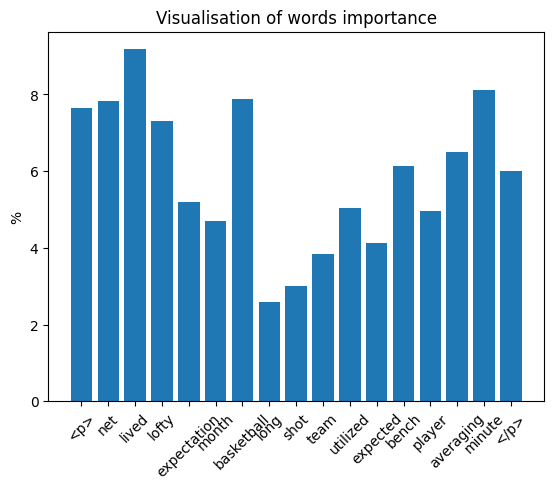

(tensor([[ 0.0075, -0.0391,  0.0677,  ...,  0.1094,  0.0157,  0.0059]],
        device='cuda:0', grad_fn=<MaxBackward0>),
 array([[ 0, 15, 12, ..., 13,  3,  3]]))

In [49]:
infersent.visualize(train_sentence_1, tokenize=True)

Predict on test sentences

In [55]:
test_embeddings = infersent.encode(test_sentences, tokenize=True)

/content/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


K-nearest neighbors

In [57]:
n_neighbors = 5  # 5 neighbours to get similarity
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
# train on Infersense embeddings
knn.fit(embeddings)

NearestNeighbors(metric='cosine')

In [58]:
distances, indices = knn.kneighbors(test_embeddings)

In [59]:
for n in n_values:
    correct_predictions = 0

    for i in range(total_predictions):
        neighbor_indices = indices[i]
        neighbor_event_ids = [train_event_ids[idx] for idx in neighbor_indices]
        correct_event_id = test_event_ids[i]

        # Check if the correct event ID is among the top N predictions
        if correct_event_id in neighbor_event_ids[:n]:
            correct_predictions += 1

    top_n_accuracy = correct_predictions / total_predictions
    print(f"Top-{n} Accuracy: {top_n_accuracy:.4f}")

Top-1 Accuracy: 0.8206
Top-3 Accuracy: 0.9103
Top-5 Accuracy: 0.9332
